In [1]:
import numpy as np


First we define our molecule using the PySCFDriver

In [2]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [3]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals

print('Number of electrons is',n_el)
print('Numberr of molecular orbitals is',n_mo)
print('Number of spin-orbitals is',n_so)
print('Number of qubits required is',n_q)


Number of electrons is 4
Numberr of molecular orbitals is 6
Number of spin-orbitals is 12
Number of qubits required is 12


Now we create an ElectronicStructureProblem and then map it to our qubits. We first calculate the exact energy with no transformers and JordanWigner mapping as a benchmark. 

In the JordanWigner mapping a qubit represents a spin-orbital.


In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)
# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()
# Hamiltonian
main_op = second_q_ops[0]

In [5]:
from qiskit_nature.mappers.second_quantization import ParityMapper,JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper)
num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

In [6]:
from qiskit_nature.circuit.library import HartreeFock
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

      ┌───┐
 q_0: ┤ X ├
      ├───┤
 q_1: ┤ X ├
      └───┘
 q_2: ─────
           
 q_3: ─────
           
 q_4: ─────
           
 q_5: ─────
      ┌───┐
 q_6: ┤ X ├
      ├───┤
 q_7: ┤ X ├
      └───┘
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
           
q_11: ─────
           


In [7]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
print(result_exact)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.74455828]
    - computed part:      [0.0  0.0  4.74455828]
  > Dipole moment (a.u.): [0.0  0.0  -1.82039607]  Total: 1.82039607
                 (debye): [0.0  0.0  -4.62698485]  Total: 4.62698485
 


In [8]:
initial_exact_energy=np.real(result_exact.eigenenergies[0])
initial_exact_energy

-8.908697116424243

Now we get a 12 qubit circuit and an energy which we can compare with. Now we try to reduce our number of qubits.

Now we use a transformer to freeze the core electrons and remove the orbitals which don't contribute significantly to the Hamiltonian

In [9]:
from qiskit_nature.transformers import FreezeCoreTransformer
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(qmolecule,remove_orbitals=[3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

Now we use a ParityMapper, two_qubit_reduction and Z<sup>2</sup> symmetries of the Hamiltonian to reduce the number of Qubits required.   

In [10]:
mapper=ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True,z2symmetry_reduction=[1])

In [11]:
num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


We get a 4 qubit circuit which results in an energy eigenvalue sufficiently close to our initial result.

If we remove any more orbitals then the Hamiltonian will not be able to reflect the molecule accurately.

In [12]:
result_exact = exact_diagonalizer(problem, converter)
print('Computed energy is',(result_exact.computed_energies[0]))
print('FreezeCoreTransformer extracted energy part is',(result_exact.extracted_transformer_energy))
print('Ground State Energy is',(result_exact.computed_energies[0])+(result_exact.extracted_transformer_energy))

Computed energy is -1.0887060157347412
FreezeCoreTransformer extracted energy part is -7.818690295581148
Ground State Energy is -8.907396311315889


Now we make our ansatz circuit. 3 is the minimum number of CNOTs you need to connect 4 qubits

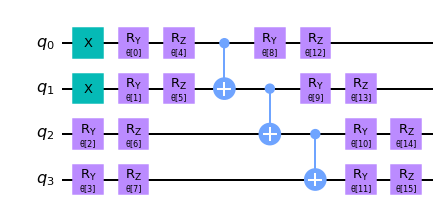

In [13]:
from qiskit.circuit.library import TwoLocal
ansatz_type = "TwoLocal"
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry', 'rz']
# Entangling gates
entanglement_blocks = 'cx'
# How the qubits are entangled 
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Skip the final rotation_blocks layer
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions,
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw()

In [14]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

Then we use a classical optimiser to find our 16 parameters 

In [15]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=15000)

In [16]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01]* len(ansatz.ordered_parameters) 
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
energy=result.optimal_value+result_exact.extracted_transformer_energy
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 15000,
    'eigenstate': array([ 1.30043312e-03+4.09329362e-04j, -4.51487091e-03-2.46028356e-03j,
        8.71548764e-03+1.95991332e-02j, -7.95141351e-01-5.92539916e-01j,
       -4.17440574e-02-3.27628443e-02j, -3.81455279e-04-6.16561407e-04j,
        1.89346644e-04+6.49111787e-04j, -1.01172212e-02-1.81637625e-02j,
       -2.37898814e-03-5.25373839e-04j, -2.18548676e-05-1.52234203e-05j,
        7.10404081e-06-1.48293086e-06j,  3.26070609e-04+1.31268137e-04j,
        9.10423309e-02+6.79057723e-02j,  7.01181486e-04+1.11396524e-03j,
       -4.19908461e-04-3.94286255e-04j, -4.63453251e-04-9.08860898e-04j]),
    'eigenvalue': -1.0863215917392375,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 2.8901587552938297,
                              ParameterVectorElement(θ[10]): 0.04289321128538392,
                              ParameterVectorElement(θ[13]): 0.14114256364535704,
                              ParameterVe

Now we compare our computed value with our initial exact energy

In [17]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-initial_exact_energy)*1000,
        'pass': (energy-initial_exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Display and save the data
import pandas as pd
result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,16,"[ry, rz]",cx,linear,1,3.685229,True,3
